# ROMY Event Catalog

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# from andbro__savefig import __savefig
from obspy.clients.fdsn import Client

## Configurations

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [3]:
config = {}

## ROMY coordinates
config['ROMY_lon'] = 11.275501
config['ROMY_lat'] = 48.162941

## minimal magnitude
config['minmagnitude'] = 6.0

## first region specified
config['minlatitude'] = -90
config['maxlatitude'] = 90
config['minlongitude'] = -180
config['maxlongitude'] = 180

config['eventfile'] = "ROMY_global_catalog"


config['tbeg'] = obs.UTCDateTime("2019-01-01")
config['tend'] = obs.UTCDateTime("2024-04-30")


config['outpath'] = data_path+"romy_events/data/catalogs/"
# config['outpath'] = "./data/"

config['outpath_figs'] = data_path+"romy_events/figures/"

## adjust eventfile name
config['eventfile'] += f"_{str(config['tbeg'].date).replace('-','')}"
config['eventfile'] += f"_{str(config['tend'].date).replace('-','')}"

config['str_dates'] = f"{str(config['tbeg'].date).replace('-','')}_{str(config['tend'].date).replace('-','')}"

In [4]:
from functions.catalog_to_dataframe import __catalog_to_dataframe
from functions.add_distances_and_backazimuth import __add_distances_and_backazimuth

In [5]:
def __export_new_events(config, events_old, events):

    ## combine new and old catalog
    tmp = pd.concat([__cat_to_df(events_old), __cat_to_df(events)]).reset_index(drop=False)
    ## remove duplicates
    df = tmp.drop_duplicates(subset=['index'], keep=False)
    ## sort and set index
    df = df.sort_index(ascending=False)
    df.set_index('index', inplace=True, drop=True)

    ## export new events to pickle file
    print(f" -> export new events: {config['outpath']}new_events.pkl")
    df.to_pickle(config['outpath']+"new_events.pkl")

    del tmp, df

## Get Events

In [6]:
client = Client("ISC")

## events - all in area and time period
events = client.get_events(
                           minlatitude=config['minlatitude'], maxlatitude=config['maxlatitude'],
                           minlongitude=config['minlongitude'], maxlongitude=config['maxlongitude'],
                           minmagnitude=config['minmagnitude'],
                           starttime=config['tbeg'], endtime=config['tend'],
                           )

In [7]:
print(f" -> storing: {config['outpath']}{config['eventfile']}.xml")
events.write(config['outpath']+config['eventfile']+".xml", format="QUAKEML")

 -> storing: /import/kilauea-data/romy_events/data/catalogs/ROMY_global_catalog_20190101_20240430.xml


### converting to dataframe

In [8]:
## convert catalog object to data frame
events_df = __catalog_to_dataframe(events)

events_df = events_df.rename_axis('timestamp').reset_index()
events_df['seconds'] = [abs((events_df.timestamp.min()-tt).total_seconds()) for tt in events_df.timestamp]
events_df

,timestamp,latitude,longitude,depth,magnitude,type,seconds
0,2019-01-04 06:24:16.200,-27.9600,-172.6600,5000.0,6.03,mb,0.000000e+00
1,2019-01-05 19:25:38.000,-8.1802,-71.6436,583477.7,6.30,mb,1.332818e+05
2,2019-01-06 17:27:19.630,2.3041,126.7147,48386.1,6.15,mb,2.125834e+05
3,2019-01-08 12:39:30.820,30.5733,131.2115,32697.4,5.81,mb,3.681146e+05
4,2019-01-15 18:06:36.200,-13.4074,166.8097,54284.2,5.94,mb,9.925400e+05
...,...,...,...,...,...,...,...
1164,2024-04-23 22:42:24.370,-17.6178,-178.8382,541268.0,4.86,mb,1.673291e+08
1165,2024-04-24 05:27:52.020,-30.1719,-177.4805,10000.0,5.38,mb,1.673534e+08
1166,2024-04-27 08:35:35.900,27.8630,139.5310,518200.0,5.84,M,1.676239e+08
1167,2024-04-27 16:29:45.120,-7.9160,107.3200,71000.0,6.08,Mw,1.676523e+08


### add distances and backazimuth

In [9]:
## add epicentral distances
__add_distances_and_backazimuth(config, events_df)

,timestamp,latitude,longitude,depth,magnitude,type,seconds,backazimuth,distances_km
0,2019-01-04 06:24:16.200,-27.9600,-172.6600,5000.0,6.03,mb,0.000000e+00,9.861260,17736.186488
1,2019-01-05 19:25:38.000,-8.1802,-71.6436,583477.7,6.30,mb,1.332818e+05,259.452974,10159.784920
2,2019-01-06 17:27:19.630,2.3041,126.7147,48386.1,6.15,mb,2.125834e+05,68.838795,11666.901912
3,2019-01-08 12:39:30.820,30.5733,131.2115,32697.4,5.81,mb,3.681146e+05,48.473355,9438.885512
4,2019-01-15 18:06:36.200,-13.4074,166.8097,54284.2,5.94,mb,9.925400e+05,38.357811,15542.253850
...,...,...,...,...,...,...,...,...,...
1164,2024-04-23 22:42:24.370,-17.6178,-178.8382,541268.0,4.86,mb,1.673291e+08,18.444150,16494.914547
1165,2024-04-24 05:27:52.020,-30.1719,-177.4805,10000.0,5.38,mb,1.673534e+08,23.265545,17873.821025
1166,2024-04-27 08:35:35.900,27.8630,139.5310,518200.0,5.84,M,1.676239e+08,43.909283,10136.052851
1167,2024-04-27 16:29:45.120,-7.9160,107.3200,71000.0,6.08,Mw,1.676523e+08,90.655824,11108.644001


In [10]:
events_df = events_df[events_df.magnitude > config['minmagnitude']]

events_df.reset_index(drop=True, inplace=True)

In [11]:
events_df[events_df.magnitude > 9]

,timestamp,latitude,longitude,depth,magnitude,type,seconds,backazimuth,distances_km
218,2022-05-31 06:04:25.530,17.9827,-67.0538,9240.0,9.15,M,1.073940e+08,273.949853,7681.769561
230,2022-07-21 09:21:49.350,17.9707,-66.9613,9760.0,9.67,M,1.118123e+08,273.873597,7675.852103
262,2022-09-19 04:58:32.320,17.9292,-66.8133,9710.0,9.63,M,1.169805e+08,273.734863,7668.143794


In [23]:
events_df = events_df[events_df.magnitude < 9]

In [24]:
events_df

,timestamp,latitude,longitude,depth,magnitude,type,seconds,backazimuth,distances_km
0,2019-01-04 06:24:16.200,-27.9600,-172.6600,5000.0,6.03,mb,0.000000e+00,9.861260,17736.186488
1,2019-01-05 19:25:38.000,-8.1802,-71.6436,583477.7,6.30,mb,1.332818e+05,259.452974,10159.784920
2,2019-01-06 17:27:19.630,2.3041,126.7147,48386.1,6.15,mb,2.125834e+05,68.838795,11666.901912
3,2019-01-20 01:32:51.840,-30.0772,-71.3177,65457.4,6.54,mb,1.364916e+06,244.236683,11925.552182
4,2019-01-22 05:10:05.180,-10.2877,119.1299,34717.2,6.04,mb,1.550749e+06,83.386067,12178.866673
...,...,...,...,...,...,...,...,...,...
506,2024-04-15 22:38:59.000,29.4000,131.7000,NaN,6.10,Mwp,1.666377e+08,48.804818,9572.239736
507,2024-04-17 14:14:47.940,33.2380,132.1610,38800.0,6.18,M,1.667802e+08,46.269221,9249.862671
508,2024-04-22 18:32:50.210,23.9330,121.6310,10000.0,6.31,M,1.672277e+08,59.287613,9449.603923
509,2024-04-27 16:29:45.120,-7.9160,107.3200,71000.0,6.08,Mw,1.676523e+08,90.655824,11108.644001


### store catalogs

In [25]:
## write data frame as pickle file
events_df.to_pickle(config['outpath']+config['eventfile']+".pkl")

## Request Focal Mechanisms

In [13]:
from functions.request_CMT_events import __request_CMT_events

# !rm /import/kilauea-data/BSPF/data/catalogs/gcmt_solutions_20221001_20230930.xml

__request_CMT_events(starttime=config['tbeg'], endtime=config['tend'], outtype="QUAKEML", outfile=config['outpath']+f"gcmt_solutions_{config['str_dates']}.xml")

# cgmt = obs.read_events(config['outpath']+'gcmt_solutions_{config['str_dates']}.xml')

/home/brotzer/notebooks/RomyEvents/functions/request_CMT_events.py:95: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if unit is "Nm":


 -> store catalog as: /import/kilauea-data/romy_events/data/catalogs/gcmt_solutions_20190101_20240430.xml


## Plot Event Timeline

In [69]:
def __plot_timeline(catalog_all_df):

    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    cmap = plt.get_cmap('viridis', 7)

    cax = ax.scatter(catalog_all_df.timestamp, catalog_all_df.distances_km, s=2**catalog_all_df.magnitude,
                     c=catalog_all_df.magnitude, alpha=0.6, cmap=cmap, zorder=2)


    cbar = plt.colorbar(cax, ax=ax, pad=0.01)
    cbar.set_label("Magnitude", fontsize=14)
    cax.set_clim(6, 9.5)

    ax.set_ylim(bottom=0)
    ax.set_ylabel("Distance (km)", fontsize=14)

    ax.grid(ls=":", zorder=-1)

    ax.set_xlim(config['tbeg']-15*86400, config['tend']+15*86400)

    ax.text(config['tend']-10*86400, catalog_all_df.distances_km.max(), f"Events={len(catalog_all_df)}", ha="right")

    plt.show();
    return fig

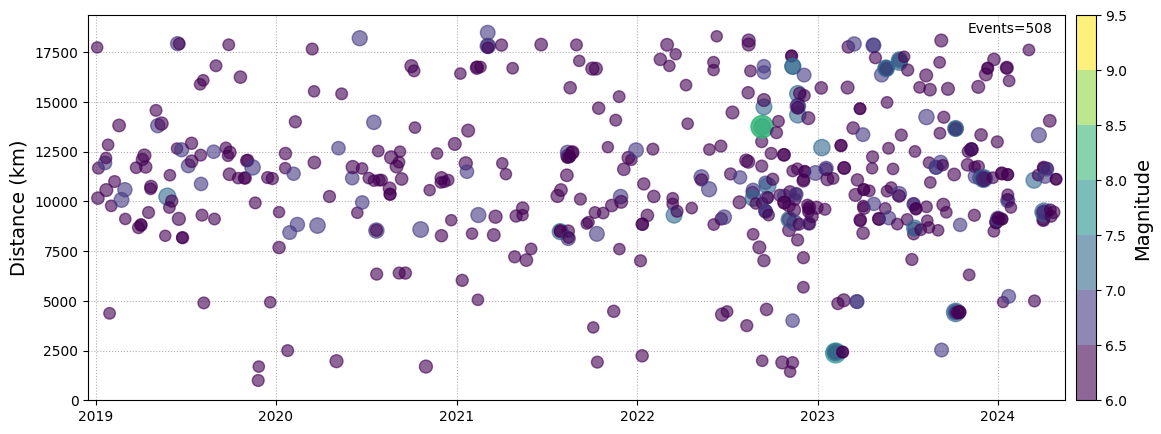

In [70]:
fig = __plot_timeline(events_df)

fig.savefig(config['outpath_figs']+f"Plot_timeline_{config['eventfile']}_{config['str_dates']}.png", dpi=150, bbox_inches="tight", pad_inches=0.05)


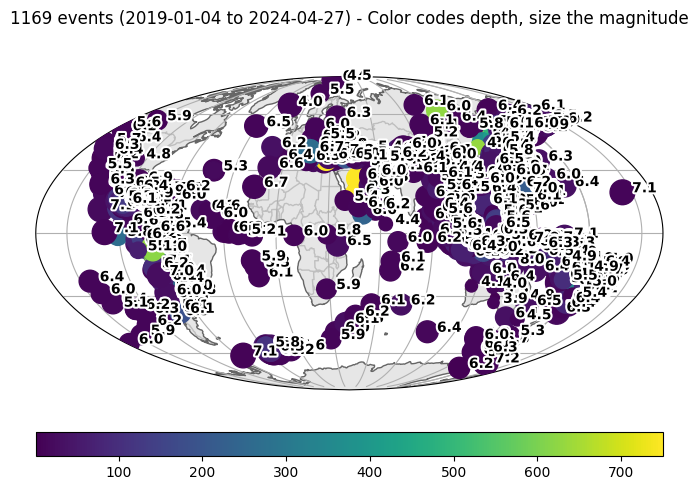

In [17]:
events.plot();